<h1 align="center"><b>Visualización de Datos</b>
<hr>

## Instalacion y configuracion de librerias

1. Instalación de TextMining

In [24]:
library(tm)
library(caret)
library(ggplot2)

## Exportacion de los datos y creacion de corpus

2. Tomaremos como factor o variable dependiente las palabras negativas (Label == 0), para ello crearemos una columna con ese nombre y ese valor

In [2]:
tweets <- read.csv("vacuna_dataset_preprocesado.csv", sep=",")

tweets$Negative <- as.factor(tweets$Label == 0)

table(tweets$Negative)

tweet_corpus <- Corpus(VectorSource(tweets$Tweet))


FALSE  TRUE 
 1412   629 

3. Haremos algunas transformaciones al corpus para poder hacer un buen modelo

In [20]:
install.packages('e1071')
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
#tweet_corpus
clean_corpus <- function(corp){
  corp <- tm_map(corp, content_transformer(tolower))
  corp <- tm_map(corp, removePunctuation)
  corp <- tm_map(corp, removeWords, stopwords('en'))
  corp <- tm_map(corp, stemDocument)
}

clean_corp <- clean_corpus(tweet_corpus)
frequencies <- TermDocumentMatrix(clean_corp)

Warning message in tm_map.SimpleCorpus(corp, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corp, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corp, removeWords, stopwords("en")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corp, stemDocument):
“transformation drops documents”


4. Creamos un DocumentTermMatrix, ya sabemos que es para tener la cantidad de palabras en un tweet, donde la fila es el tweet, y la columna la palabra

In [9]:
dtm <- DocumentTermMatrix(clean_corp)
sparseData <- removeSparseTerms(dtm, sparse=0.995)
sparsedf <- as.data.frame(as.matrix(sparseData))
colnames(sparsedf) <- make.names(colnames(sparsedf))
sparsedf$Negative <- tweets$Negative

5. Crearemos data de test y de entrenamiento a partir de nuestro propio dataset

In [15]:
library(MASS)
library(caTools)


In [16]:
set.seed(101)
split <- sample.split(sparsedf$Negative, SplitRatio = 0.7)
trainSparse <- subset(sparsedf, split==TRUE)
testSparse <- subset(sparsedf, split==FALSE)

6. Crearemos el modelo de arbol regresional, y un objeto para la prediccion

In [17]:
tweet.CART <- rpart(Negative~., trainSparse, method='class')
predictCART <- predict(tweet.CART, testSparse, type='class')

Visualizamos un arbol para ver graficamente

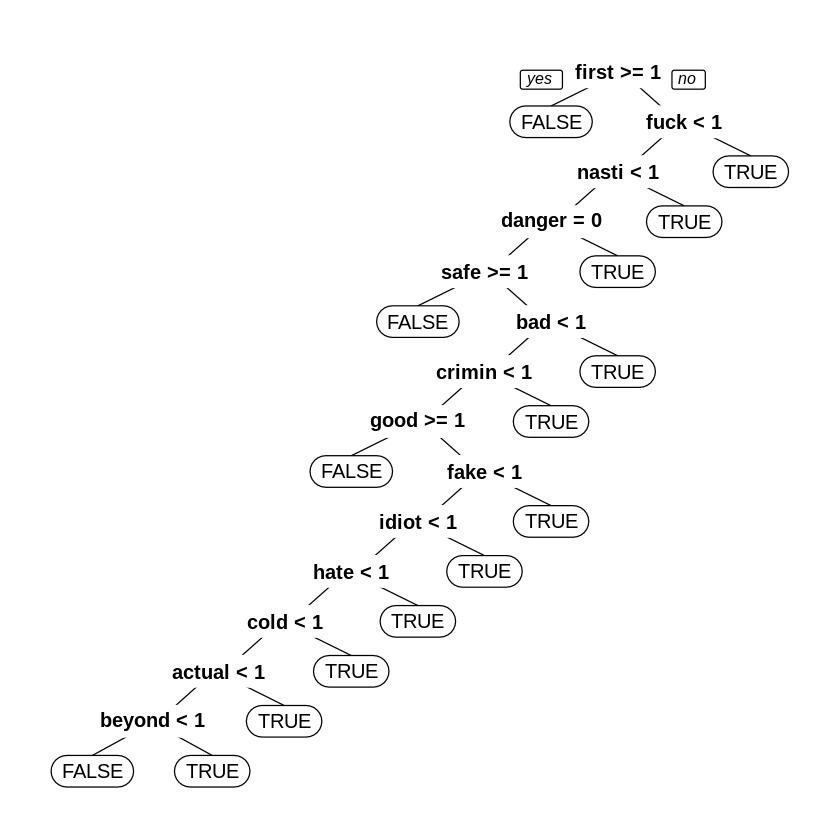

In [26]:
prp(tweet.CART)

7. Entrenamos el modelo para que podamos realizar la prediccion

In [21]:
control <- trainControl(method='cv', number=10)
metric <- 'Accuracy'
set.seed(101)
tweet.cart <- train(Negative~., data=trainSparse, method='rpart',
                    trControl=control, metric=metric)

tweet.pred <- predict(tweet.cart, testSparse)


8. Comprobamos nuestra predicción con una matriz de confusion

In [22]:
confusionMatrix(tweet.pred, testSparse$Negative)

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   418  163
     TRUE      6   26
                                          
               Accuracy : 0.7243          
                 95% CI : (0.6871, 0.7593)
    No Information Rate : 0.6917          
    P-Value [Acc > NIR] : 0.04299         
                                          
                  Kappa : 0.1603          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.9858          
            Specificity : 0.1376          
         Pos Pred Value : 0.7194          
         Neg Pred Value : 0.8125          
             Prevalence : 0.6917          
         Detection Rate : 0.6819          
   Detection Prevalence : 0.9478          
      Balanced Accuracy : 0.5617          
                                          
       'Positive' Class : FALSE           
                     